## Logistic Regression

Playground notebook for implementing logistic regression on preprocessed data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report
# %matplotlib inline

In [2]:
# load preprocessed data
df = pd.read_parquet('../data/preprocessed.parquet')

# split predictor and target variables to X and y respectively
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 


### Encoding Categorical Variables

Of the 19 attributes, 15 of them are categorical variables. From our EDA, we observe that these variables are nominal in nature with no natural order. Hence we can simply employ one-hot encoding to convert them to numerical values

In [4]:
def OneHotEncoding(data):
    """
    Function to perform One Hot Encoding on Categorical Variables

    Args: 
        data [dataframe]: data with only predictor variables to have categorical attributes encoded

    Returns:
        data_encoded [dataframe]: data with predictor variables encoded
    """
    # create copy of data
    data_encoded = data.copy()

    # grab categorical column names
    cat_vars = data_encoded.select_dtypes(include=['object']).columns.tolist()    

    # encode 
    for var in cat_vars:
        data_encoded = pd.get_dummies(data_encoded,columns=[var])

    return data_encoded

In [5]:
X_encoded = OneHotEncoding(X)

### Dealing with Class Imbalance

From the EDA, we observed that number of users that didn't churned exceeds those that did by quite a far bit. This issue of class imbalance has to be addressed before fitting the model.

Failure to address this issue might lead to high accuracy in predicting the majority class (users that didn't churn) but fail to capture the minority class.

I'll leverage on over-sanmpling as the approach to deal with class imbalance. The technique used here will be Synthetic Minority Oversampling Technique, or SMOTE, which generates synthetic data for the minority class.

**What is SMOTE?**  
>SMOTE (Synthetic Minority Oversampling Technique) works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=0)


In [7]:
def apply_smotenc (X,y):
    """
    Function to apply SMOTE on dataset

    Args:
        X [dataframe]: dataframe with predictor variables and can only contain continuous variables. NaN values are not allowed
        Y [dataframe]: dataframe with target variables. NaN values are not allowed

    Returns:
        x_smote_df [dataframe]: final predictor dataset with SMOTE
        y_smote_df [dataframe]: final target dataset with SMOTE
    
    """
    

    try:
        # initialise SMOTENC
        smote_nc = SMOTE()

        # fit predictor and target variable
        x_smote, y_smote = smote_nc.fit_resample(X.to_numpy(),y.to_numpy())

    except Exception as e:
        print(e)

    finally:
        # convert x and y arrays to dataframe
        x_smote_df = pd.DataFrame(x_smote,columns=X.columns)
        y_smote_df = pd.DataFrame(y_smote,columns=[y.name])

        return x_smote_df, y_smote_df

In [14]:
X_train_smote, y_train_smote = apply_smotenc(X_train, y_train)

In [15]:
print(np.shape(X_train_smote))
print(np.shape(y_train_smote))

(8250, 45)
(8250, 1)


After applying SMOTE, we have successfully balanced the churn class to equal ratio.

### Applying Logistic Regression

In [17]:
# initialise log regression
logreg = LogisticRegression(max_iter=400)

# fit model with daata
logreg.fit(X_train_smote,y_train_smote);

y_pred = logreg.predict(X_test);

/Users/leonsun/Documents/GitHub/churn-model/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Model Evaluation

In [18]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          No       0.91      0.74      0.81      1038
         Yes       0.52      0.80      0.63       369

    accuracy                           0.75      1407
   macro avg       0.71      0.77      0.72      1407
weighted avg       0.81      0.75      0.77      1407



In [20]:
def plot_cnf_matrix (y_test,y_pred):
    """
    Function to plot confusion matrix

    Args:
        y_test [Series]: series object for target variables, partitioned into test set
        y_pred [Array or Series]: array or series object of predicted target variable. Length must be the same as y_test
    
    Returns:
        fig [matplotlib figure]: matplotlib figure object rendered
    
    """

    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    return fig

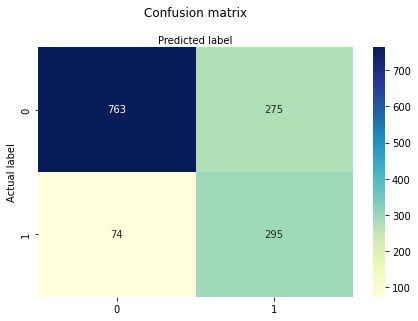

In [21]:
cnf_matrix = plot_cnf_matrix(y_test,y_pred)

In [22]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred,pos_label='Yes'))
print("Recall:",metrics.recall_score(y_test, y_pred,pos_label='Yes'))


Accuracy: 0.751954513148543
Precision: 0.5175438596491229
Recall: 0.7994579945799458


**Accuracy**
Our accuracy score (or Classification Rate) is 75.2%, considered as a reasonable good accuracy.

**Precision**
Precision measures how accurate the model is when making a prediction (ho often it is correct). Our precision score is 51.8%, which means that the Logistic Regression model successfully predict users are going to churn 52.9% of the time. 

**Recall**
Our recall score is 79.6%, which means the Logistic Regression model can identfy users who have churn 79.9% of the time.

In [29]:
def plot_roc_curve (X_test, y_test,logreg):
    """
    Function to plot ROC Curve

    Args:
        X_test (Series): series object of predictor variables, partitioned into test set
        y_test [Series]: series object for target variables, partitioned into test set

    Returns:
        fig [matplotlib figure]: matplotlib figure object rendered
    """
    y_pred_proba = logreg.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba,pos_label='Yes')
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    fig, ax = plt.subplots()
    ax.plot(fpr,tpr,label="auc="+str(auc))
    plt.title('ROC Curve', y=1.1)
    plt.legend(loc=4)
    plt.show()

    return fig
    

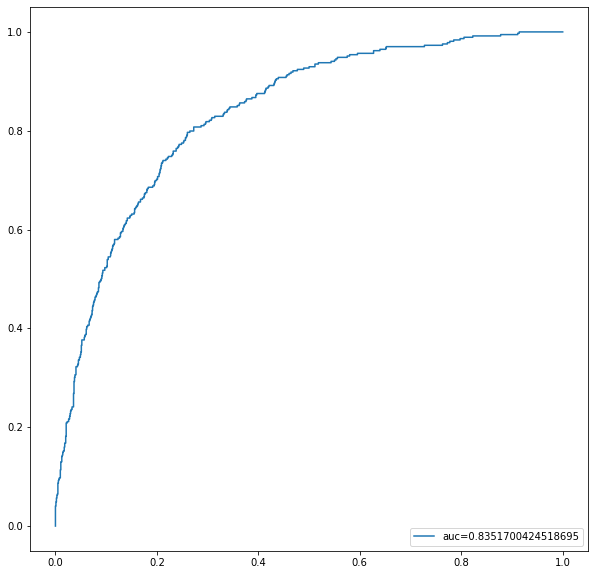

In [30]:
roc_curve = plot_roc_curve(X_test, y_test, logreg)

Our AUC score is 0.835. AUC Score of 1 represents perfec classifier, and 0.5 represents a worthless classifier. In this case, our AUC looks decent.

### Feature Importance

In [41]:
def plot_feat_impt (logreg):
    """
    Function to plot feature importance

    Args:
        logreg [model instance]: Log Regression model instance

    Returns:
        fig [matplotlib figure]: matplotlib figure 
    """
    feat_importance = logreg.coef_.flatten()
    fig, ax = plt.subplots(figsize=(10,10))
    # plt.rcParams["figure.figsize"] = (10,10)
    ax.barh(X_encoded.columns, feat_importance, color='g')
    plt.title("Barplot Summary of Feature Importance")
    plt.xlabel("Score")
    plt.show()
    return fig

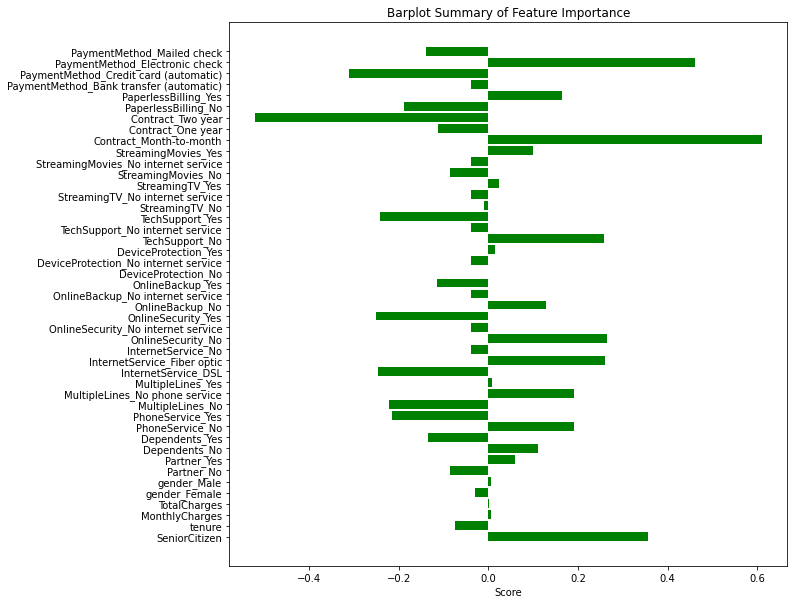

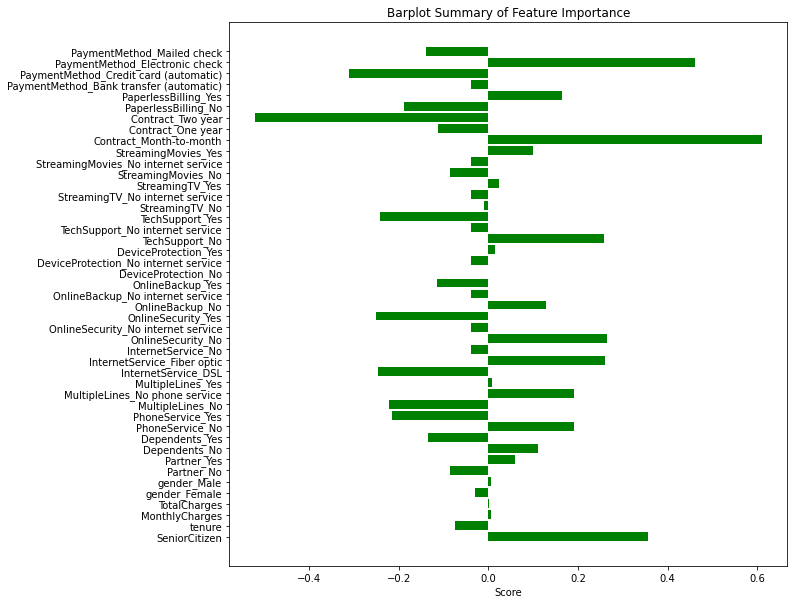

In [42]:
plot_feat_impt(logreg)

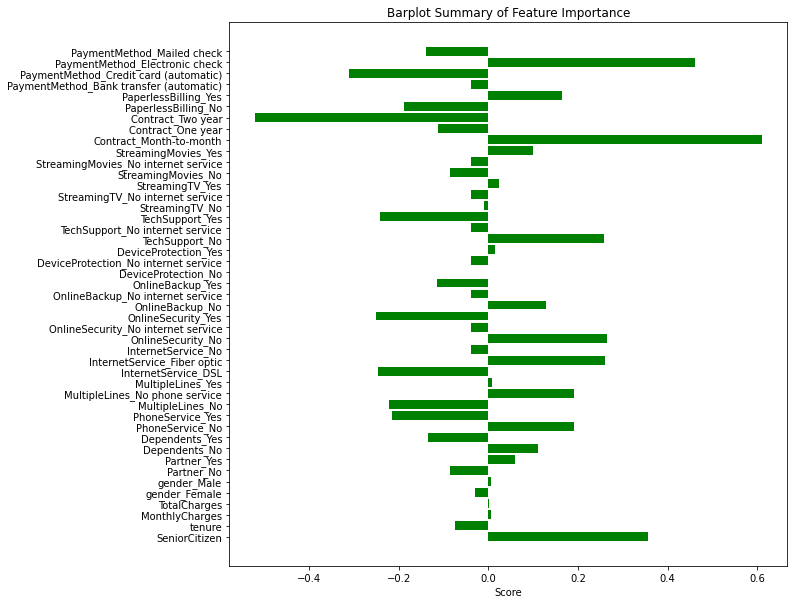

In [40]:
feat_importance = logreg.coef_.flatten()

fig, ax = plt.subplots(figsize=(10,10))
# plt.rcParams["figure.figsize"] = (10,10)
ax.barh(X_encoded.columns, feat_importance, color='g')
plt.title("Barplot Summary of Feature Importance")
plt.xlabel("Score")
plt.show()